In [2]:
import os
import sys
import itertools
import numpy as np

from scipy import stats

# These libs are for figure plotting
# Make sure that project-NN-Pytorch-scripts in your PYTHONPATH
from tutorials.plot_tools import plot_API
from tutorials.plot_tools import plot_lib

# How to use

1. Check the Example sections;

2. If you have time read Introduction below, otherwise skip it;

3. Run the script by yourself, or use it on your own data.



# Introduction

## Issue 1
In many cases, it is unsound to claim that the algorithm in system A is better than that in system B because the system A achieved 1.92% EER while B got 2.01%. Sometimes the difference between EERs (1.92% vs 2.01%) is purely due to some random factors other than the technical difference between A and B. 

It is helpful to run the experiments multiple times and compute the average results. Another tool is a statistical significance test. Although it is a silver bullet, it can help. A statistical significance test compares EERs of multiple CMs and judges whether the difference between each pair of EERs is statistical significant. 
Given the EERs of system A and B, it assumes that system A and B are `the same`, computes a few statitics, measures the probablity of observing each statistic, and suggests an answer.

The answer would be either:

* Given the assumption that A and B are `the same` (null hypothesis), the computed probability suggests that, if we repeat the experiments many times (say $M$), more than $\alpha M$ times, we will see that the difference between the EERs of A and B will be larger than the difference between 1.92% and 2.01%. Even under the null hypothesis (A and B are the same!), the chance to observe a difference as large as abs(1.92% - 2.01%) is **not rare**, how can we believe that A and B are intrinsically different?  **Thus, we cannot reject the null hypothesis which assumes that A and B are `the same`;**

* Given the assumption that A and B are `the same` (null hypothesis), the computed probability suggests that, if we repeat the experiments many times (say $M$), less than $\alpha M$ times, we will see that the difference between the EERs of A and B will be larger than the difference between 1.92% and 2.01%. Therefore, under the null hypothesis (A and B are the same!), the chance to observe a difference as large as abs(1.92% - 2.01%) is **rare**, and we have strong evidence to believe that A and B are intrinsically different. **Thus, we can reject the null hypothesis which assumes that A and B are `the same`;**

$\alpha$ is the significance level, which is usually 0.01, 0.05, or 0.1.

## Issue 2

Then more tests we do, the higher chance we will find at least one significant difference.  In this case, we can adjust the $\alpha$ and be more conservative when judge the significance of the difference. This is done through methods called correction.  Here, we will use Holm-Bonferroni correction.


## Reference

I am not confident to explain the theory. Let me know if my explaination is incorrect. This notebook are based on the following references:

* Online textbook on significance test: Richard Lowry, Concepts & Applications of Inferential Statistics http://vassarstats.net/textbook/

* Significance test for biometric, used in this notebook: Samy Bengio, and Johnny Mariéthoz. A Statistical Significance Test for Person Authentication. In Proc. Odyssey. 2004.

* Correction in multiple comparisons (multiple significance tests): Hervé Abdi, and others. Bonferroni and Šidák Corrections for Multiple Comparisons. Encyclopedia of Measurement and Statistics 3. Sage Thousand Oaks, CA: 103–107. 2007.

# Functions

Some functions for convenience

## For equal error rate computation

In [3]:
# From ASVspoof official tDCF https://www.asvspoof.org/resources/tDCF_python_v2.zip

def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size
    all_scores = np.concatenate((target_scores, nontarget_scores))
    labels = np.concatenate((np.ones(target_scores.size),
                             np.zeros(nontarget_scores.size)))

    # Sort labels based on scores                                                         
    indices = np.argsort(all_scores, kind='mergesort')
    labels = labels[indices]

    # Compute false rejection and false acceptance rates                                  
    tar_trial_sums = np.cumsum(labels)
    nontarget_trial_sums = (nontarget_scores.size -
                            (np.arange(1, n_scores + 1) - tar_trial_sums))

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums/target_scores.size))
    # false rejection rates                                                               
    far = np.concatenate((np.atleast_1d(1),
                          nontarget_trial_sums / nontarget_scores.size))
    # false acceptance rates                                                              
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.001),
                                 all_scores[indices]))
    # Thresholds are the sorted scores                                                    
    return frr, far, thresholds


def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]


## For z-value computation

This is based on Samy Bengio, and Johnny Mariéthoz. A Statistical Significance Test for Person Authentication. In Proc. Odyssey. 2004.

In [4]:
def compute_z_independent(far_a, frr_a, far_b, frr_b, NI, NC):
    """z = compute_HTER_independent(hter_a, hter_b, NI, NC)
    
    Bengio, S. & Mariéthoz, J. A statistical significance test for 
    person authentication. in Proc. Odyssey (2004). 
    
    Fig2. independent case
    
    input
    -----
      far_a: float, far of system a, which be >=0 and <=1
      frr_a: float, frr of system a, which be >=0 and <=1
      far_b: float, far of system b, which be >=0 and <=1
      frr_b: float, frr of system b, which be >=0 and <=1
      NI: int, the number of impostor accesses.
      NC: int, the number of client accesses.
      
    output
    ------
      z: float, statitics of the hypothesis test
    """
    # 
    hter_a = (far_a + frr_a)/2
    hter_b = (far_b + frr_b)/2
    denominator  = (far_a * (1 - far_a) + far_b * (1 - far_b)) / 4 / NI 
    denominator += (frr_a * (1 - frr_a) + frr_b * (1 - frr_b)) / 4 / NC 
    return np.abs(hter_a - hter_b) / np.sqrt(denominator)
    
    
def compute_z_dependent(far_ab, frr_ab, far_ba, frr_ba, NI, NC):
    """z = compute_HTER_independent(hter_a, hter_b, NI, NC)
    
    Bengio, S. & Mariéthoz, J. A statistical significance test for 
    person authentication. in Proc. Odyssey (2004). 
    
    Fig2. dependent case
    
    input
    -----
      far_ab: float, see paper
      frr_ab: float, see paper 
      far_ba: float, see paper 
      frr_ba: float, see paper 
      NI: int, the number of impostor accesses.
      NC: int, the number of client accesses.
      
    output
    ------
      z: float, statitics of the hypothesis test
    """
    # 
    if far_ab == far_ba and frr_ab == frr_ba:
        return 0
    else:
        denominator = np.sqrt((far_ab + far_ba) / (4 * NI) + (frr_ab + frr_ba) / (4 * NC))
        return np.abs(far_ab + frr_ab - far_ba - frr_ba) / denominator

    

def get_eer(scores_positive, scores_negative):
    """eer, threshold = get_eer(scores_positive, scores_negative)
    
    compute Equal Error Rate given input scores
    
    input
    -----
      scores_positive: np.array, scores of positive class
      scores_negative: np.array, scores of negative class
    
    output
    ------
      eer: float, equal error rate
      threshold: float, the threshold for the err
      
    """
    return compute_eer(scores_positive, scores_negative)
    
    
def get_far_frr_dependent(bona_score_a, spoof_score_a, threshold_a, 
                          bona_score_b, spoof_score_b, threshold_b, 
                          NI, NC):
    """
    """
    far_ab_idx = np.bitwise_and(spoof_score_a < threshold_a, spoof_score_b >= threshold_b)
    far_ba_idx = np.bitwise_and(spoof_score_a >= threshold_a, spoof_score_b < threshold_b)
    frr_ab_idx = np.bitwise_and(bona_score_a >= threshold_a, bona_score_b < threshold_b)
    frr_ba_idx = np.bitwise_and(bona_score_a < threshold_a, bona_score_b >= threshold_b)

    far_ab = np.sum(far_ab_idx) / NI
    far_ba = np.sum(far_ba_idx) / NI
    frr_ab = np.sum(frr_ab_idx) / NC
    frr_ba = np.sum(frr_ba_idx) / NC
    return far_ab, far_ba, frr_ab, frr_ba


## For significant test and correction


In [5]:
# Note
# Bengio, S. & Mariéthoz, J. A statistical significance test for person authentication. in Proc. Odyssey (2004). 
# assumes two-sided test
# Z_alpha/2 in Fig.2 of the above paper

def compute_Z_alpha2(significance_level, alternative='two-sided'):
    if alternative == 'less':
        Z_alpha2 = stats.norm.ppf(significance_level)
    elif alternative == 'greater':
        Z_alpha2 = stats.norm.isf(significance_level)
    elif alternative == 'two-sided':
        Z_alpha2 = stats.norm.isf(significance_level/2)
    else:
        raise ValueError("alternative must be "
                         "'less', 'greater' or 'two-sided'")
    return Z_alpha2

print("Z_alpha/2 for 90% CI (alpha=0.10): {:.4f}".format(compute_Z_alpha2(0.10)))
print("Z_alpha/2 for 95% CI (alpha=0.05): {:.4f}".format(compute_Z_alpha2(0.05)))
print("Z_alpha/2 for 99% CI (alpha=0.01): {:.4f}".format(compute_Z_alpha2(0.01)))

Z_alpha/2 for 90% CI (alpha=0.10): 1.6449
Z_alpha/2 for 95% CI (alpha=0.05): 1.9600
Z_alpha/2 for 99% CI (alpha=0.01): 2.5758


We need to compute the z_value for two systems in comparison. We then compare the z_value with the Z_alpha/2 above.

* If $z > Z_{\alpha/2}$, we reject the null hypothesis, and we cannot say that the two systems are not significantly different. 

* else, we CANNOT reject the null hypothesis 


However, the more tests we do, the higher chance that we will find a large z_value that will reject the null hypothesis.

For more tests, we need to adjust $Z_{\alpha/2}$ and make it more difficult to reject the null hypothesis. This is called "Correction", and this topic is covered in Reference 2 above.

Below are functions for some of the correction methods

In [6]:
# Hypothesis testing with correction
#
def reject_null_bonferroni_naive(z_values, num_test, significance_level, alternative='two-sided', 
                                 accept_value=True, reject_value=False):
    """result = reject_null_bonferroni_naive(z_values, significance_level)
    
    native bonferroni correction
    https://en.wikipedia.org/wiki/Bonferroni_correction
    
    input
    -----
      z_values: np.array, an array of z_value
      num_test: int, number of tests in the experiment
      signifiance_level: float, common choise is 0.1, 0.05, or 0.01

    output
    ------
      result: np.array, same size as z_values, if result[i] is True if z_value[i]
         is larger than the threshold
    """
    #num_test = z_values.size
    corrected_conf_level = significance_level / num_test
    Z_alpha2 = compute_Z_alpha2(corrected_conf_level, alternative)

    # reject null hypothesis
    idx_reject = z_values > Z_alpha2
    # acccept null hypothesis
    idx_accept = z_values <= Z_alpha2
    
    result = np.zeros(z_values.shape)
    result[idx_accept] = accept_value
    result[idx_reject] = reject_value
    return result


def reject_null_sidak(z_values, num_test, significance_level, alternative='two-sided', 
                      accept_value=True, reject_value=False):
    """ similar API to reject_null_bonferroni_naive
    
    See Hervé Abdi, and others. Bonferroni and Šidák Corrections for Multiple Comparisons. 
    Encyclopedia of Measurement and Statistics 3. Sage Thousand Oaks, CA: 103–107. 2007.
    """
    #num_test = z_values.size
    #FWER = 1 - (1 - significance_level) ** (1 / num_test)
    corrected_conf_level = 1 - (1 - significance_level) ** (1 / num_test)
    Z_alpha2 = compute_Z_alpha2(corrected_conf_level, alternative)
    
    idx_reject = z_values >= Z_alpha2
    idx_accept = z_values < Z_alpha2
    result = np.zeros(z_values.shape)
    result[idx_accept] = accept_value
    result[idx_reject] = reject_value
    return result


def reject_null_holm_bonferroni(z_values, num_test, significance_level, alternative='two-sided', 
                                accept_value=True, reject_value=False):
    """ similar API to reject_null_bonferroni_naive
    
    See https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method
    """
    # get the index of each z_value in the sorted array
    # large z corresponds to small p
    # we start with the case where the z is the largest
    order = np.argsort(z_values.flatten())[::-1]
    
    # a result buffer, by default, set all to accept
    result_buff = np.zeros(order.shape) + accept_value
    
    # conduct the test 
    for test_idx, data_idx in enumerate(order):
        # the test coming first should receive a more strict Z_alpha
        corrected_conf_level = significance_level / (num_test - test_idx)
        Z_alpha2 = compute_Z_alpha2(corrected_conf_level, alternative)
        #print(corrected_conf_level)
        if z_values.flatten()[data_idx] < Z_alpha2:
            # if we cannot reject, stop testing
            result_buff[data_idx] = accept_value
            break
        else:
            result_buff[data_idx] = reject_value
    
    return np.reshape(result_buff, z_values.shape)


def reject_null_holm_bonferroni_given_p_value(p_values, num_test, significance_level, 
                                              accept_value=True, reject_value=False):
    """ Demonstration given p_values
    See Example in https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method
    """
    # get the index of each p_value in the sorted array
    # small p comes first
    order = np.argsort(p_values.flatten())
    
    # a result buffer, by default, set all to accept
    result_buff = np.zeros(order.shape) + accept_value
    
    # conduct the test 
    for test_idx, data_idx in enumerate(order):
        # the test coming first should receive a more strict Z_alpha
        corrected_conf_level = significance_level / (num_test - test_idx)
        
        print("Compare p-value {:.3f} with corrected alpha {:.4f}".format(
            p_values.flatten()[data_idx], corrected_conf_level), end=' ')
        # here smaller p_value is more significant
        if p_values.flatten()[data_idx] > corrected_conf_level:
            # if we cannot reject, stop testing
            result_buff[data_idx] = accept_value
            print("accept NULL, stop")
            break
        else:
            result_buff[data_idx] = reject_value
            print("reject NULL")
    
    return np.reshape(result_buff, p_values.shape)


In [7]:
# Here is one example using p-values for the test
# See example in https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method
# Note that this example uses p_value, 
# a smaller p_value indicates higher confidence to reject NULL

# While in S.Bengio's paper, the paper is conducted given a z_value 
# Thus the API is different
p_values = np.array([[0.01, 0.04], [0.03, 0.005]])
print(reject_null_holm_bonferroni_given_p_value(p_values, 4, 0.05))

# 0.01 and 0.005 are rejected while 0.04 and 0.03 are accepted

Compare p-value 0.005 with corrected alpha 0.0125 reject NULL
Compare p-value 0.010 with corrected alpha 0.0167 reject NULL
Compare p-value 0.030 with corrected alpha 0.0250 accept NULL, stop
[[0. 1.]
 [1. 0.]]


# Example

For significance test on CM, we first need to get the EERs.

Given the EERs, and number of trials for bonafide / spoof, we can conduct significance tests.

## Hypothesis test for model A and B

Create two sets of score distributions for A and B, compute EERs, and conduct hypothesis test

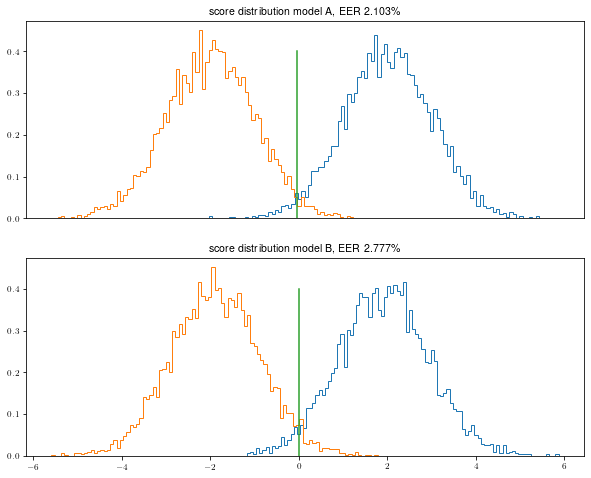

In [8]:
# produce scores for model A and B
# number of trials for bona fide (positive class)
NC = 5000
# number of trials for spoof (negative class)
NI = 7500

model_A_bonafide_scores = np.random.randn(NC) + 2.0
model_A_spoof_scores = np.random.randn(NI) - 2.0
eer_A, threshold_A = get_eer(model_A_bonafide_scores, model_A_spoof_scores)


model_B_bonafide_scores = np.random.randn(NC) + 1.9
model_B_spoof_scores = np.random.randn(NI) - 1.9
eer_B, threshold_B = get_eer(model_B_bonafide_scores, model_B_spoof_scores)


# plotting
threshold_line_A = np.array([[threshold_A, 0], [threshold_A, 0.4]])
threshold_line_B = np.array([[threshold_B, 0], [threshold_B, 0.4]])

fig, axis = plot_API.plot_API2(
    [model_A_bonafide_scores, model_A_spoof_scores, threshold_line_A,
     model_B_bonafide_scores, model_B_spoof_scores, threshold_line_B], 
    [plot_lib.plot_hist, plot_lib.plot_hist, plot_lib.plot_signal,
     plot_lib.plot_hist, plot_lib.plot_hist, plot_lib.plot_signal], 
    [[[0, 1], [0, 1]] for x in range(3)] + [[[1, 2], [0, 1]] for x in range(3)], 
    {'figsize': (10, 8), 'sharex': True,
     'subtitle': [{'title': 'score distribution model A, EER {:.3f}\%'.format(eer_A*100)},{},{},
                  {'title': 'score distribution model B, EER {:.3f}\%'.format(eer_B*100)},{},{}]})

Do significance test using the EERs

In [9]:
# input
z_value = compute_z_independent(eer_A, eer_A, eer_B, eer_B, NI, NC) #Here, EER = FAR = FRR = HTER
significance_level = 0.05

# output
#. the number of test is 1 for this examples
test_output_mat = reject_null_holm_bonferroni(np.array([z_value]), z_value.size, significance_level)


if test_output_mat[0]:
    print("Accept Null hypothesis, and we can say that model A and B's performance are not significantly different")
else:
    print("Reject Null hypothesis, and we cannot say that model A and B's performance are not significantly different")

Reject Null hypothesis, and we cannot say that model A and B's performance are not significantly different


## Hypothesis test for model A, B, C, D

Example to compare system A, B, C, D

(<Figure size 720x576 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x155527137fa0>])

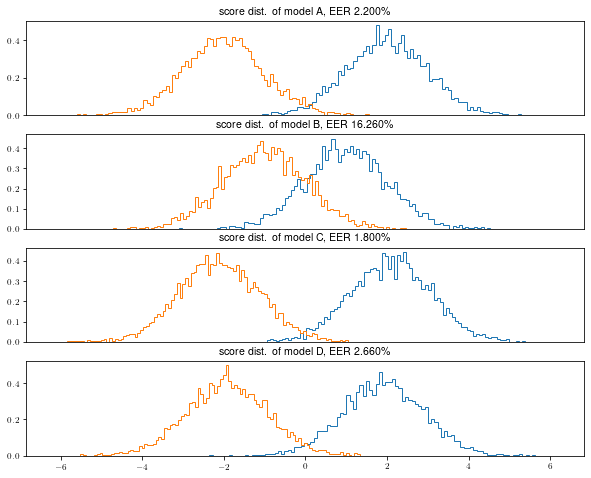

In [10]:
# produce scores for a, b, c, d
NC = 5000
NI = 7500

tags = ['A', 'B', 'C', 'D']
shift_values = [[-2, 2], [-1, 1], [-2.1, 2.1], [-1.9, 1.9]]

score_bags_bona = []
score_bags_spoof = []
eer_bags = []
for shift_value_pair in shift_values:
    bona_score = np.random.randn(NC) + shift_value_pair[1]
    spoof_score = np.random.randn(NC) + shift_value_pair[0]
    eer, threshold = get_eer(bona_score, spoof_score)
    score_bags_bona.append(bona_score)
    score_bags_spoof.append(spoof_score)
    eer_bags.append(eer)

    
# plotting score dist.
score_bags = score_bags_bona + score_bags_spoof
plot_API.plot_API2(
    score_bags_bona + score_bags_spoof, 
    [plot_lib.plot_hist for x in score_bags],
    [[[x%(len(tags)), (x)%(len(tags))+1], [0, 1]] for x in range(len(score_bags))], 
    {'figsize': (10, 8), 'sharex': True,
    'subtitle': 
     [{'title': 'score dist. of model {:s}, EER {:.3f}\%'.format(tag, eer*100)} for tag, eer in zip(tags+tags, eer_bags+eer_bags)]})

Conduct multiple significance test with Holm-bonferroni correction

In [11]:
# Here, EER = FAR = FRR = HTER
# get the z_values

z_values = np.zeros([len(tags), len(tags)])
for idx1, tag1 in enumerate(tags):
    for idx2, tag2 in enumerate(tags):
        z_values[idx1, idx2] = compute_z_independent(
            eer_bags[idx1], eer_bags[idx1], eer_bags[idx2], eer_bags[idx2], NI, NC)


In [12]:
# Conduct test
# Assuming a very conservative approach and treat all the four systems from a single source

# input:
#  z_values
#  significance_levl

# output:
#  test_output_mat: 

significance_level = 0.05
test_output_mat = reject_null_holm_bonferroni(z_values, z_values.size, significance_level)

for idx1, tag1 in enumerate(tags):
    for idx2, tag2 in enumerate(tags):
        if idx1 < idx2:
            if test_output_mat[idx1, idx2]:
                print("Model {:s} and {:s}'s performance not significantly different".format(tag1, tag2))
            else:
                print("Model {:s} and {:s}'s performance significantly different".format(tag1, tag2))

Model A and B's performance significantly different
Model A and C's performance not significantly different
Model A and D's performance not significantly different
Model B and C's performance significantly different
Model B and D's performance significantly different
Model C and D's performance significantly different


# Example for ASVspoof and ploting figures

Example below is similar to what we used for ASVspoof CM. 

We have N systems, each of which ran M times. 

We can use figures to visualize the significance test results.

In [13]:
def plot_mat(test_result, system_list, runs,  cmap='RdBu'):
    """plot_mat(test_result, system_list, runs,  cmap='RdBu')
    
    input
    -----
      test_results: np.array, (system_list * runs, system_list * runs)
      system_list: list of string, list of the system names
      runs: int, number of runs for each system
      cmap: cmap for Matpotlib
    """
    ticklabels = range(len(system_list) * runs)[runs//2::runs]            
    
    total=len(system_list)*runs
    temp_lines = np.linspace(0, len(system_list)*runs, len(system_list)+1)
    data_list = [np.stack([np.array([0-.5, total-0.5]), np.array([x-0.5, x-0.5])], axis=1) for x in temp_lines]
    data_list = data_list + [np.stack([np.array([x-0.5, x-0.5]), np.array([0-.5, total-0.5])], axis=1) for x in temp_lines]
    data_list = data_list + [np.stack([np.array([0-0.5, total-0.5]), np.array([0-.5, total-0.5])], axis=1)]
    
    print(temp_lines)
    fig, axis = plot_API.plot_API2([test_result, data_list], [plot_lib.plot_imshow, plot_lib.plot_signal], [[[0,1],[0,1]], [[0,1],[0,1]]], 
                      {'figsize': (10, 10),
                       'sub': [
                       {'plot_imshow': {'cmap': cmap, 'origin': 'lower', 'aspect':'auto', 'interpolation': 'nearest'},
                       'yticks': ticklabels,
                       'yticklabels': {'labels': system_list, 'rotation': 0},
                       'xticks': ticklabels,
                       'xticklabels': {'labels': system_list, 'rotation': 90},
                       #'xlim': (-0.5, total-0.5),
                       #'ylim': (-0.5, total-0.5)
                       },
                       {'plot_signal': {'color': 'k', 'linewidth': 2.0, 'alpha':1.0}},]})
    return fig, axis

## Preparation: simulate the score distributions for a new systems, compute EERs

In [14]:
# produce scores for system 1 - 12
# and assume each system is trained/evaluated for 4 times
NC = 5000
NI = 7500
runs = 6

tags = ['system {:d}'.format(x) for x in range(12)]

# create data for the 12 systems 
#  use Gaussian with different means
shift_values = [[-2, 2], [-2, 2], [-2.01, 2.01], [-1.9, 1.9], 
                [-2.2, -2.1], [-2.1, -2.4], [-4.2, -1.2], [-3.8, -1.8],
                [-2.2, -2.1], [-2.1, -2.4], [-4.2, -1.2], [-3.8, -1.8],]
score_bags_bona = []
score_bags_spoof = []

eer_bags = np.zeros([len(shift_values), runs])
for sys_idx, shift_value_pair in enumerate(shift_values):
    for run_idx in range(runs):
        bona_score = np.random.randn(NC) + shift_value_pair[1]
        spoof_score = np.random.randn(NC) + shift_value_pair[0]
        eer, threshold = get_eer(bona_score, spoof_score)
        score_bags_bona.append(bona_score)
        score_bags_spoof.append(spoof_score)
        eer_bags[sys_idx, run_idx ] = eer
    

In [15]:
print(eer_bags)
print(eer_bags.shape)
# 12 systems, 6 runs per system

[[0.023  0.0256 0.0228 0.0212 0.0226 0.0264]
 [0.0222 0.0234 0.02   0.0178 0.0242 0.022 ]
 [0.0222 0.0216 0.0224 0.0244 0.0212 0.0232]
 [0.0312 0.0292 0.0278 0.0276 0.0278 0.0258]
 [0.4822 0.482  0.4788 0.486  0.4832 0.477 ]
 [0.5614 0.5598 0.5666 0.5596 0.5568 0.5558]
 [0.0702 0.0678 0.0712 0.0666 0.0632 0.066 ]
 [0.1606 0.1582 0.1558 0.152  0.1602 0.1558]
 [0.4764 0.479  0.4806 0.4716 0.4876 0.4842]
 [0.5672 0.553  0.5638 0.5552 0.5624 0.5612]
 [0.0662 0.0656 0.0628 0.071  0.0642 0.0622]
 [0.1586 0.151  0.1546 0.1526 0.1602 0.1604]]
(12, 6)


(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x155527099bb0>)

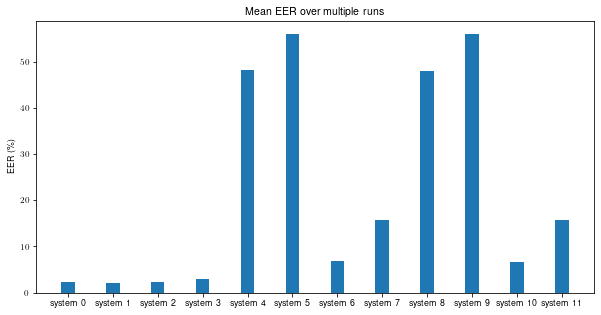

In [16]:
plot_API.plot_API(eer_bags.mean(axis=1) * 100, plot_lib.plot_bar, 'single', 
                  {'xticks': range(eer_bags.shape[0]), 'xticklabels': tags, 'ylabel': 'EER (\%)', 'title': 'Mean EER over multiple runs'})

Once we know the EERs per systems, we can conduct significance test

## Method 1: Multiple tests within a pair of systems

Given EERs, compute z_values in a pair-wise way

In [17]:
def sig_test_holm_bonf_method1(eer_bags, NI, NC, significance_level=0.05):
    """ test_results = sig_test_holm_bonf_method1(eer_bags, sig_level, NI, NC):
    
    Args:
      eer_bags: np.array, shape (N, M), where N is the number of systems, and M is the number of 
          random runs
      NI: int, number of bona fide trials in test set
      NC: int, number of spoofed trials in test set
      sig_level: float, significance level, default 0.05
      
    Return:
      test_results: np.array, shape (N*M, N*M), 
           test_results[i*M+j, l*M+n] shows the significance test between the j-th run of i-th system
           and the n-th run of the l-th system
    
    Note: 
      test_results[i*M+j, l*M+n] == True: accept NULL hypothesis, no significant different
    """
    # get the reject/accept
    #significance_level = 0.05

    num_system = eer_bags.shape[0]
    runs = eer_bags.shape[1]
    
    z_values = np.zeros([num_system * runs, num_system * runs])
    test_results = np.zeros(z_values.shape)

    for sys_1_idx in range(num_system):
        for sys_2_idx in range(num_system):
            # compute z_values 
            # significance test must be conducted within this pair of system
            z_value_tmp = np.zeros([runs, runs])
            for run_idx1 in range(runs):
                for run_idx2 in range(runs):
                    idx1 = sys_1_idx * runs + run_idx1
                    idx2 = sys_2_idx * runs + run_idx2
                    z_values[idx1, idx2] = compute_z_independent(
                        eer_bags[sys_1_idx, run_idx1], 
                        eer_bags[sys_1_idx, run_idx1], 
                        eer_bags[sys_2_idx, run_idx2], 
                        eer_bags[sys_2_idx, run_idx2], 
                        NI, NC)
                    z_value_tmp[run_idx1, run_idx2] = z_values[idx1, idx2]
            # do a test
            test_result_tmp = reject_null_holm_bonferroni(z_value_tmp, z_value_tmp.size, significance_level)
            # save results
            test_results[sys_1_idx * runs : (sys_1_idx + 1) * runs, sys_2_idx * runs : (sys_2_idx + 1) * runs] = test_result_tmp
    return test_results

In [18]:
# conduct the test
test_results = sig_test_holm_bonf_method1(eer_bags, NI, NC, 0.05)

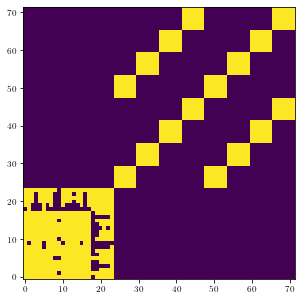

In [19]:
# you can plot this matrix using imshow
import matplotlib.pyplot as plt
plt.imshow(test_results, origin='low')

[ 0.  6. 12. 18. 24. 30. 36. 42. 48. 54. 60. 66. 72.]


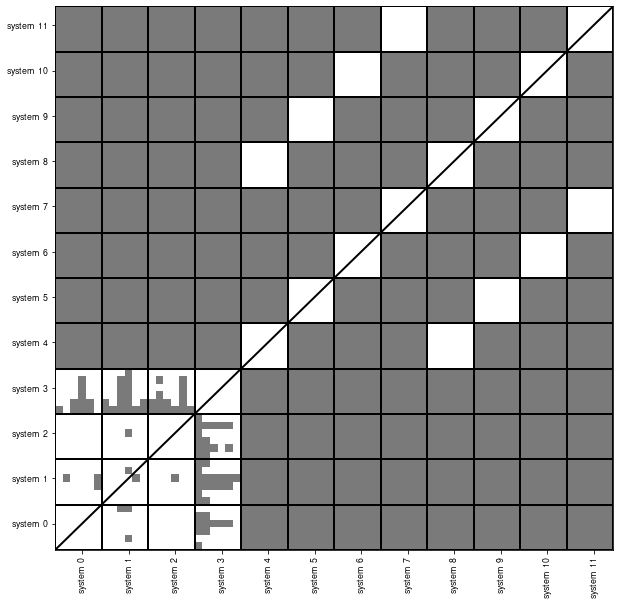

In [20]:
# I use a wrapper function to plot it
# create a customized colormap (I used some customized colors)
from matplotlib.colors import ListedColormap
newcolors = np.stack([plot_API.get_color(4, 5, 'self_3')*0.6, plot_API.get_color(0, 2, 'self_3')], axis=0)
newcmp = ListedColormap(newcolors)

# or you can use Matplotlib colormap
#newcmp = 'Greys_r'

fig, axis = plot_mat(test_results, tags, runs, newcmp)

In the above figure, a white dot indicates 'we cannot reject null hypothesis, and two pair of EERs not significantly different'

As expected, system 0, 1, 2 are not significantly different across the 6 runs.

Some other systems pairs, such as system 4 and 8, 5 and 9, 6 and 10, and 7 and 11 are not significantly different.

## Method 2: We assume all the tests are in the same family 

(very conservative approach)

In [21]:
def sig_test_holm_bonf_method2(eer_bags, NI, NC, significance_level=0.05):
    """ test_results = sig_test_holm_bonf_method2(eer_bags, sig_level, NI, NC):
    
    Args:
      eer_bags: np.array, shape (N, M), where N is the number of systems, and M is the number of 
          random runs
      NI: int, number of bona fide trials in test set
      NC: int, number of spoofed trials in test set
      sig_level: float, significance level, default 0.05
      
    Return:
      test_results: np.array, shape (N*M, N*M), 
           test_results[i*M+j, l*M+n] shows the significance test between the j-th run of i-th system
           and the n-th run of the l-th system
    
    Note: 
      test_results[i*M+j, l*M+n] == True: accept NULL hypothesis, no significant different
    """
    # get the reject/accept
    #significance_level = 0.05

    num_system = eer_bags.shape[0]
    runs = eer_bags.shape[1]
    
    z_values = np.zeros([num_system * runs, num_system * runs])
    test_results = np.zeros(z_values.shape)

    for sys_1_idx in range(num_system):
        for sys_2_idx in range(num_system):
            # compute z_values 
            # significance test must be conducted within this pair of system
            z_value_tmp = np.zeros([runs, runs])
            for run_idx1 in range(runs):
                for run_idx2 in range(runs):
                    idx1 = sys_1_idx * runs + run_idx1
                    idx2 = sys_2_idx * runs + run_idx2
                    z_values[idx1, idx2] = compute_z_independent(
                        eer_bags[sys_1_idx, run_idx1], 
                        eer_bags[sys_1_idx, run_idx1], 
                        eer_bags[sys_2_idx, run_idx2], 
                        eer_bags[sys_2_idx, run_idx2], 
                        NI, NC)
                    z_value_tmp[run_idx1, run_idx2] = z_values[idx1, idx2]
    # save results
    test_results = reject_null_holm_bonferroni(z_values, z_values.size, significance_level)
    return test_results

In [22]:
# get the reject/accept
significance_level = 0.05
test_results = sig_test_holm_bonf_method2(eer_bags, NI, NC, significance_level)

[ 0.  6. 12. 18. 24. 30. 36. 42. 48. 54. 60. 66. 72.]


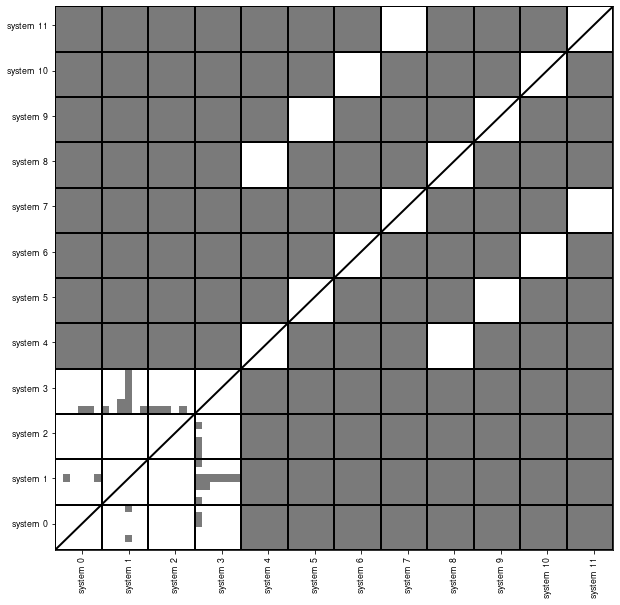

In [23]:
# create a customized colormap (I used some colors)
from matplotlib.colors import ListedColormap
newcolors = np.stack([plot_API.get_color(4, 5, 'self_3')*0.6, plot_API.get_color(0, 2, 'self_3')], axis=0)
newcmp = ListedColormap(newcolors)

# or you can use Matplotlib colormap
#newcmp = 'Greys_r'

fig, axis = plot_mat(test_results, tags, runs, newcmp)

This method is more conservative. It is more restrict to reject the null hypothesis.

Thus, we see more white dots when comparing system3 with either system 0, 1, 2